In [21]:
import vtk
import math
import operator
import numpy as np
from functools import reduce
from aicsshparam import shtools
import matplotlib.pyplot as plt
from matplotlib import animation
from vtk.util import numpy_support as vtknp
from scipy import interpolate
from skimage import measure 
import pandas as pd
import os
import math
from aicsimageio.readers.tiff_reader import TiffReader
def find_plane_mesh_intersection(mesh, proj, use_vtk_for_intersection=True):

    # Find axis orthogonal to the projection of interest
    axis = [a for a in [0, 1, 2] if a not in proj][0]

    # Get all mesh points
    points = vtknp.vtk_to_numpy(mesh.GetPoints().GetData())

    if not np.abs(points[:, axis]).sum():
        raise Exception("Only zeros found in the plane axis.")

    if use_vtk_for_intersection:

        mid = np.mean(points[:, axis])
        '''Set the plane a little off center to avoid undefined intersections.
        Without this the code hangs when the mesh has any edge aligned with the
        projection plane. Also add a little of noisy to the coordinates to
        help with the same problem.'''
        mid += 0.75
        offset = 0.1 * np.ptp(points, axis=0).max()

        # Create a vtkPlaneSource
        plane = vtk.vtkPlaneSource()
        plane.SetXResolution(4)
        plane.SetYResolution(4)
        if axis == 0:
            plane.SetOrigin(
                mid, points[:, 1].min() - offset, points[:, 2].min() - offset
            )
            plane.SetPoint1(
                mid, points[:, 1].min() - offset, points[:, 2].max() + offset
            )
            plane.SetPoint2(
                mid, points[:, 1].max() + offset, points[:, 2].min() - offset
            )
        if axis == 1:
            plane.SetOrigin(
                points[:, 0].min() - offset, mid, points[:, 2].min() - offset
            )
            plane.SetPoint1(
                points[:, 0].min() - offset, mid, points[:, 2].max() + offset
            )
            plane.SetPoint2(
                points[:, 0].max() + offset, mid, points[:, 2].min() - offset
            )
        if axis == 2:
            plane.SetOrigin(
                points[:, 0].min() - offset, points[:, 1].min() - offset, mid
            )
            plane.SetPoint1(
                points[:, 0].min() - offset, points[:, 1].max() + offset, mid
            )
            plane.SetPoint2(
                points[:, 0].max() + offset, points[:, 1].min() - offset, mid
            )
        plane.Update()
        plane = plane.GetOutput()

        # Trangulate the plane
        triangulate = vtk.vtkTriangleFilter()
        triangulate.SetInputData(plane)
        triangulate.Update()
        plane = triangulate.GetOutput()

        # Calculate intersection
        intersection = vtk.vtkIntersectionPolyDataFilter()
        intersection.SetInputData(0, mesh)
        intersection.SetInputData(1, plane)
        intersection.Update()
        intersection = intersection.GetOutput()

        # Get coordinates of intersecting points
        points = vtknp.vtk_to_numpy(intersection.GetPoints().GetData())
        coords = points[:, proj]

    else:
        
        valids = np.where((points[:,axis] > -2.5)&(points[:,axis] < 2.5))
        coords = points[valids[0]][:,proj]

    # Sorting points clockwise
    # This has been discussed here:
    # https://stackoverflow.com/questions/51074984/sorting-according-to-clockwise-point-coordinates/51075469
    # but seems not to be very efficient. Better version is proposed here:
    # https://stackoverflow.com/questions/57566806/how-to-arrange-the-huge-list-of-2d-coordinates-in-a-clokwise-direction-in-python
    center = tuple(
        map(
            operator.truediv,
            reduce(lambda x, y: map(operator.add, x, y), coords),
            [len(coords)] * 2,
        )
    )
    coords = sorted(
        coords,
        key=lambda coord: (
            -135
            - math.degrees(
                math.atan2(*tuple(map(operator.sub, coord, center))[::-1])
            )
        )
        % 360,
    )

    # Store sorted coordinates
    # points[:, proj] = coords
    return np.array(coords)

There are 313 cells in PC 1, bin 1
There are 1630 cells in PC 1, bin 3
There are 325 cells in PC 1, bin 5
There are 306 cells in PC 2, bin 1
There are 1665 cells in PC 2, bin 3
There are 371 cells in PC 2, bin 5
There are 367 cells in PC 3, bin 1
There are 1788 cells in PC 3, bin 3
There are 261 cells in PC 3, bin 5
There are 128 cells in PC 1, bin 1
There are 645 cells in PC 1, bin 3
There are 110 cells in PC 1, bin 5
There are 103 cells in PC 2, bin 1
There are 657 cells in PC 2, bin 3
There are 125 cells in PC 2, bin 5
There are 140 cells in PC 3, bin 1
There are 714 cells in PC 3, bin 3
There are 78 cells in PC 3, bin 5
There are 185 cells in PC 1, bin 1
There are 985 cells in PC 1, bin 3
There are 215 cells in PC 1, bin 5
There are 203 cells in PC 2, bin 1
There are 1008 cells in PC 2, bin 3
There are 246 cells in PC 2, bin 5
There are 227 cells in PC 3, bin 1
There are 1074 cells in PC 3, bin 3
There are 183 cells in PC 3, bin 5


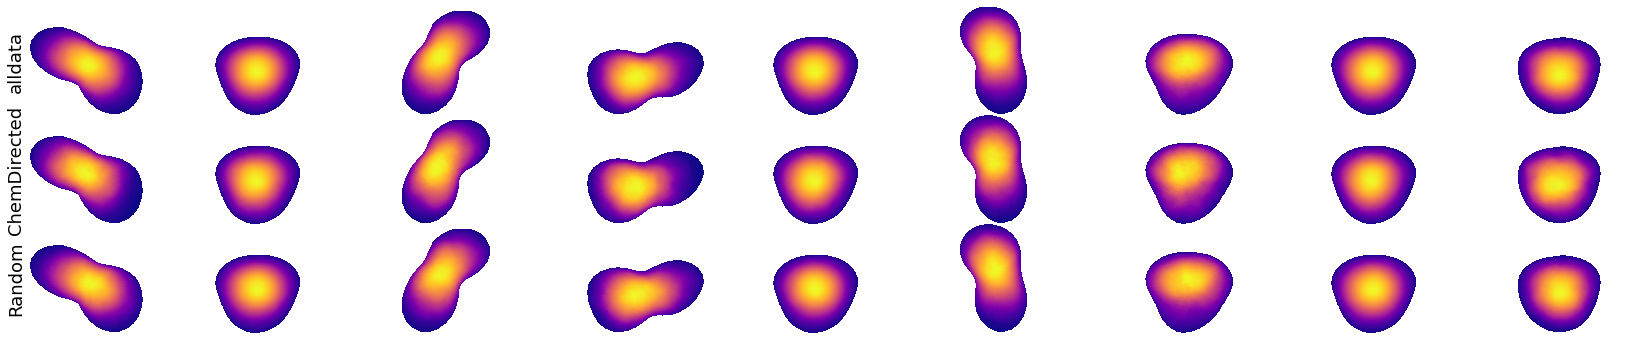

In [6]:
from scipy import interpolate
######### Graph PCs to compare between genotypes ##############
savedir = 'D:/Aaron/Data/Chemotaxis/Data_and_Figs/'
fl = 'D:/Aaron/Data/Chemotaxis/Processed_Data/avgPILRs/'
metrics = pd.read_csv(savedir+'Shape_Metrics_with_Digitized_PCs.csv', index_col=0)


struct = 'nucleus'
proj=[1,2]
pcs = 3
bins = [1, 3, 5]

xlim = 0
ylim = 0

fig, axes = plt.subplots(len(mkey), len(bins)*pcs, figsize = (30,6), sharex = True, sharey = True)
for i,m in enumerate(mkey):
    a=0
    if m == 'alldata':
        migrationmetrics = metrics.copy()
    elif m == 'Random':
        migrationmetrics = metrics[metrics.frame<41]
    elif m == 'ChemDirected':
        migrationmetrics = metrics[metrics.frame>40]
        
        
    for p in range(1,pcs+1):
        for b in bins:
            bincellsum = sum(migrationmetrics[f'PC{p}_bins']==b)
            print(f'There are {bincellsum} cells in PC {p}, bin {b}')
            ax = axes[i,a]
            imstr = f'PC{p}_bin{b}_{m}_{struct}_aggmorph.tif'
            #read image
            img = TiffReader(fl + imstr)
            #get segmented mem and nuc channel
            axis = [a for a in [0, 1, 2] if a not in proj][0]
            #get the outline of the membrane
            segmask = np.max(img.data[0], axis = axis)
            
            #get plot limits
            maxes = np.where(segmask>0)
            xmax = np.max(maxes[1])
            ymax = np.max(maxes[0])
            if xmax > xlim:
                xlim = xmax
                ax.set_xlim(0,xlim)
            if ymax > ylim:
                ylim = ymax
                ax.set_ylim(0,ylim)
            
            
            #sum the intensity signal
            sumproj = np.sum(img.data[1], axis = axis)
            #get masked image
            masked = np.ma.masked_where((segmask == 0), sumproj)
            ax.imshow(masked, cmap='plasma')
            if a == 0:
                ax.set_ylabel(m, fontsize = 18)
                ax.xaxis.set_visible(False)
                ax.tick_params(left=False, labelleft=False)
                plt.setp(ax.spines.values(), visible=False)
            else:
                ax.axis('off')
#             #get nucleus outline to show
#             contours = skmeasure.find_contours(segmask, 1)[0]
#             ax.plot(contours[:,1], contours[:,0], c='c')

#             #interpolate contours to get smoother lines
#             tck, u = interpolate.splprep(contours.T, k=3)
#             yderv = interpolate.splev(u,tck,der=0)
#             traj = np.vstack(yderv).T
#             ax.plot(traj[:-1,1], traj[:-1,0], c='m')

            a=a+1

# plt.colorbar()
# plt.tight_layout()
plt.subplots_adjust(wspace=0,
                    hspace=0)

plt.savefig(savedir+f'{struct} aggmorph PC comparison.png', bbox_inches='tight')         


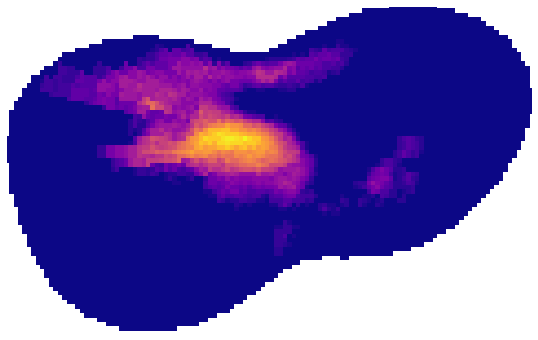

In [32]:
from scipy import interpolate
######### Graph PCs to compare between genotypes ##############
savedir = 'D:/Aaron/Data/Chemotaxis/Data_and_Figs/'
fl = 'D:/Aaron/Data/Chemotaxis/Processed_Data/avgPILRs/'
# metrics = pd.read_csv(savedir+'Shape_Metrics_with_Digitized_PCs.csv', index_col=0)


struct = 'actin'
proj=[1,2]
pcs = 3
bins = [1, 3, 5]

xlim = 0
ylim = 0

fig, ax = plt.subplots(figsize = (30,6), sharex = True, sharey = True)

fl = 'C:/Users/Aaron/Documents/Python Scripts/temp/'
imstr = '_aggmorph.tif'
#read image
img = TiffReader(fl + imstr)
#get segmented mem and nuc channel
axis = [a for a in [0, 1, 2] if a not in proj][0]
#get the outline of the membrane
segmask = np.max(img.data[0], axis = axis)

#get plot limits
maxes = np.where(segmask>0)
xmax = np.max(maxes[1])
ymax = np.max(maxes[0])
if xmax > xlim:
    xlim = xmax
    ax.set_xlim(0,xlim)
if ymax > ylim:
    ylim = ymax
    ax.set_ylim(0,ylim)


#sum the intensity signal
sumproj = np.sum(img.data[1], axis = axis)
#get masked image
masked = np.ma.masked_where((segmask == 0), sumproj)
ax.imshow(masked, cmap='plasma')
if a == 0:
    ax.set_ylabel(m, fontsize = 18)
    ax.xaxis.set_visible(False)
    ax.tick_params(left=False, labelleft=False)
    plt.setp(ax.spines.values(), visible=False)
else:
    ax.axis('off')
#             #get nucleus outline to show
#             contours = skmeasure.find_contours(segmask, 1)[0]
#             ax.plot(contours[:,1], contours[:,0], c='c')

#             #interpolate contours to get smoother lines
#             tck, u = interpolate.splprep(contours.T, k=3)
#             yderv = interpolate.splev(u,tck,der=0)
#             traj = np.vstack(yderv).T
#             ax.plot(traj[:-1,1], traj[:-1,0], c='m')

# a=a+1

# plt.colorbar()
# plt.tight_layout()
# plt.subplots_adjust(wspace=0,
#                     hspace=0)

# plt.savefig(savedir+f'{struct} aggmorph PC comparison.png', bbox_inches='tight')         


In [5]:
o

'PC10_bin1_actin_aggmorph.tif'

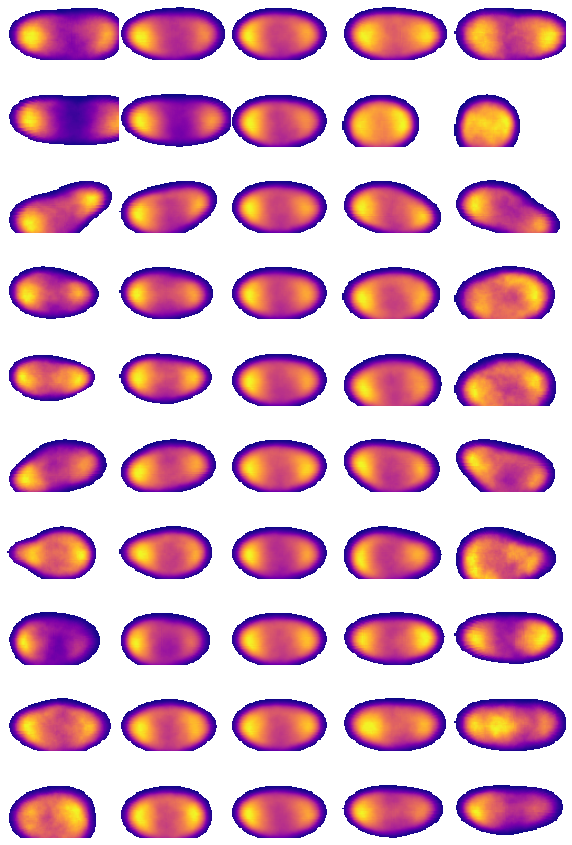

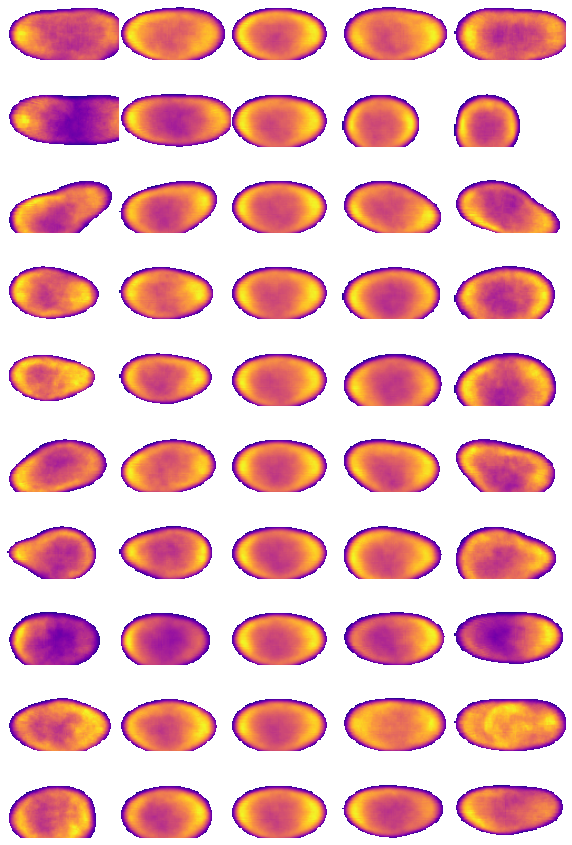

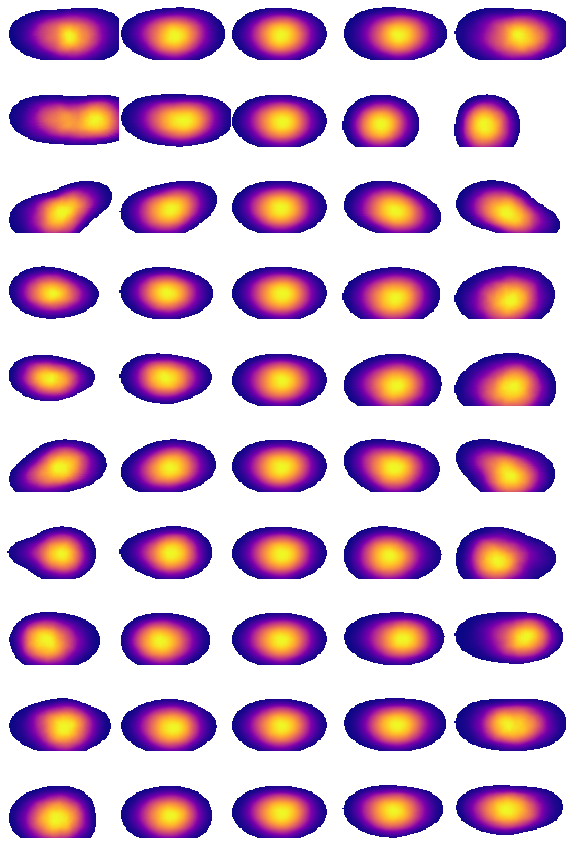

In [16]:

######### Graph PCs to compare between genotypes ##############
savedir = 'E:/Aaron/random_lls/Data_and_Figs/'
meshdir = 'E:/Aaron/random_lls/random/avgPILRs/'
morphs = [m for m in os.listdir(meshdir) if m.endswith('aggmorph.tif')]


#get keys
pckey = []
bkey = []
structkey = []
for o in morphs:
    pc, bn, st, _ = o.split('_')
    if pc not in pckey:
        pckey.append(pc)
    if bn not in bkey:
        bkey.append(bn)
    if st not in structkey:
        structkey.append(st)

proj=[0,2]
pcs = 10
bins = 5


xlim = 0
ylim = 0

for s in structkey:
    fig, axes = plt.subplots(pcs, bins, figsize = (10,30), sharex = True, sharey = True)
    for p in range(1,pcs+1):
        xmaxs = []
        ymaxs = []
        for b in range(1,bins+1):
            ax = axes[p-1,b-1]
            imstr = f'PC{p}_bin{b}_{s}_aggmorph.tif'
            #read image
            img = TiffReader(meshdir + imstr)
            #get segmented mem and nuc channel
            axis = [a for a in [0, 1, 2] if a not in proj][0]
            #get the outline of the membrane
            segmask = np.max(img.data[0], axis = axis)

            #get plot limits since the functions for it suck
            maxes = np.where(segmask>0)
            xmaxs.append(np.max(maxes[1]))
            ymaxs.append(np.max(maxes[0]))

            #sum the intensity signal
            sumproj = np.sum(img.data[1], axis = axis)
            #get masked image
            masked = np.ma.masked_where((segmask == 0), sumproj)
            ax.imshow(masked, cmap = 'plasma')

    #         #get nucleus outline to show
    #         contours = skmeasure.find_contours(segmask, 1)[0]
    #         ax.plot(contours[:,1], contours[:,0], c='c', lw = 2)

    #             #interpolate contours to get smoother lines
    #             tck, u = interpolate.splprep(contours.T, k=3)
    #             yderv = interpolate.splev(u,tck,der=0)
    #             traj = np.vstack(yderv).T
    #             ax.plot(traj[:-1,1], traj[:-1,0], c='m')

            ax.axis('off')
#         for b in range(1,bins+1):
#             ax = axes[p-1,b-1]
#             ax.set_xlim(0,max(xmaxs))
#             ax.set_ylim(0,max(ymaxs))
#     plt.tight_layout()
    plt.subplots_adjust(top = 0.7,
                        bottom =0.3,
                        wspace=0,
                        hspace=0)    

    plt.savefig(savedir+s+' aggmorph shape space sum.png', bbox_inches='tight')         


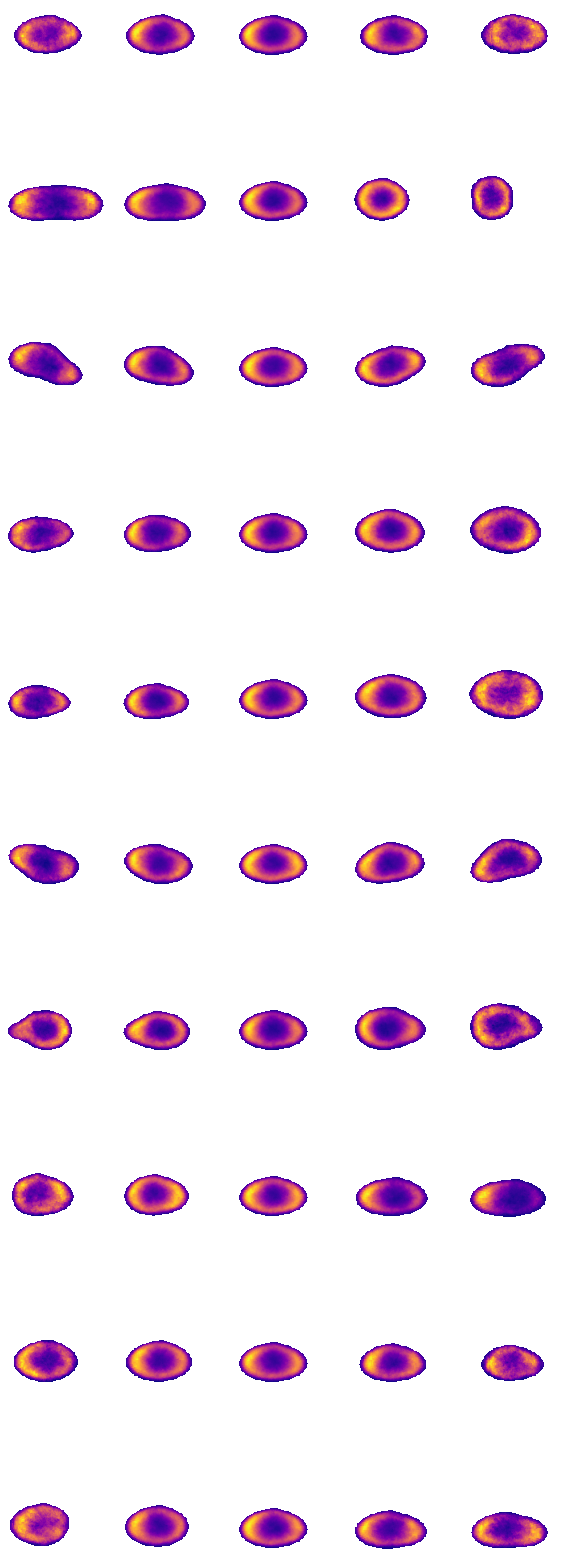

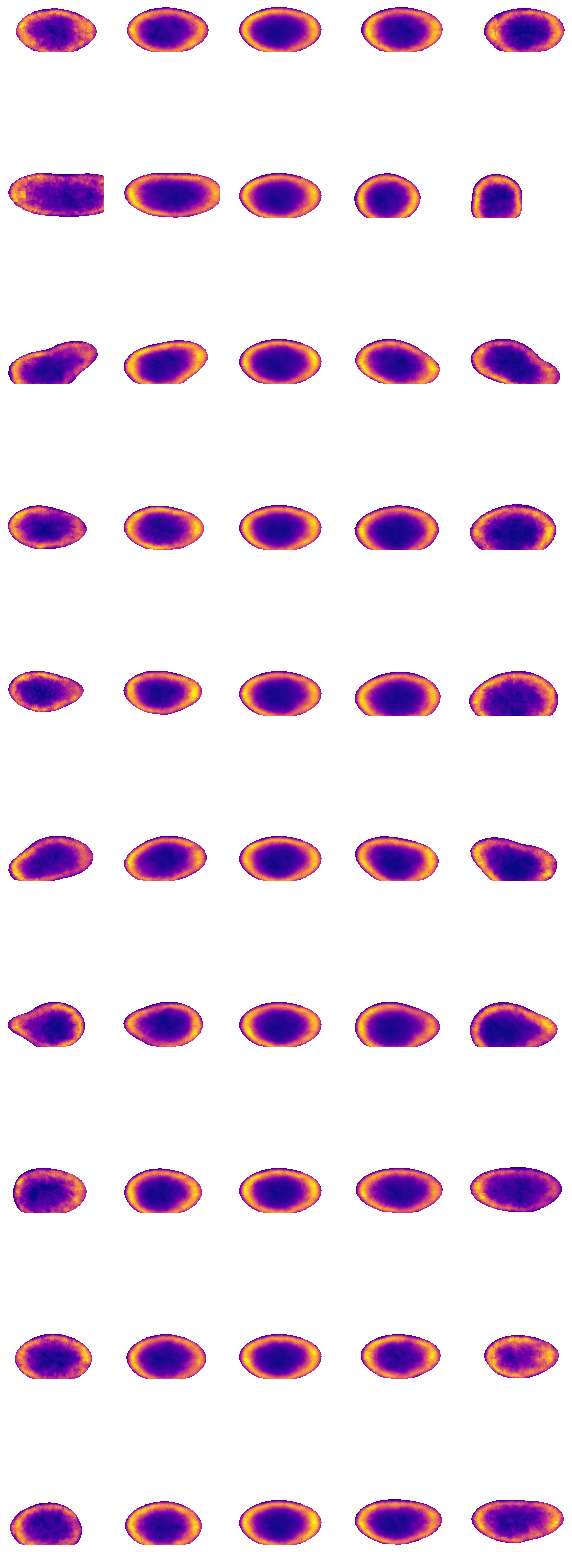

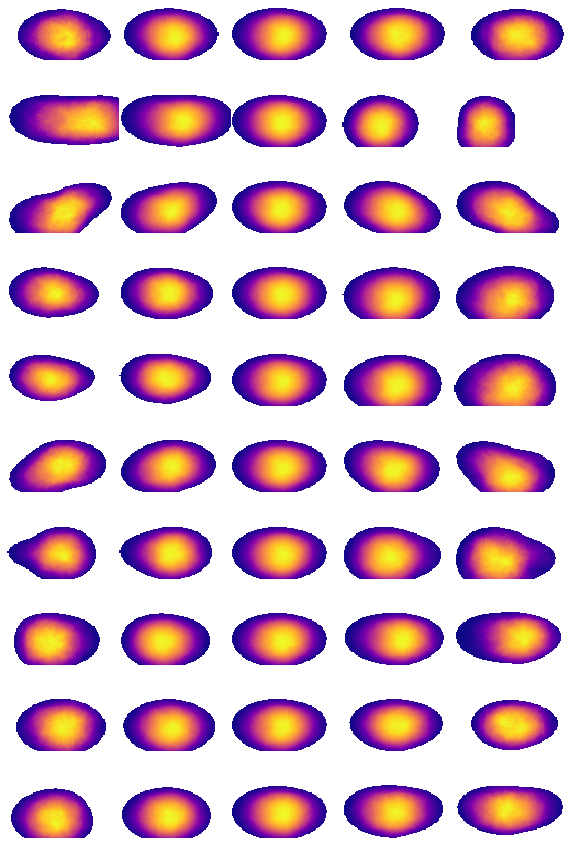

In [22]:
##################### plot structure mid slice images ################

######### Graph PCs to compare between genotypes ##############
savedir = 'E:/Aaron/random_lls/Data_and_Figs/'
meshdir = 'E:/Aaron/random_lls/random/avgPILRs/'
morphs = [m for m in os.listdir(meshdir) if m.endswith('aggmorph.tif')]

proj=[0,2]
pcs = 10
bins = 5


xlim = 0
ylim = 0

for s in structkey:
    fig, axes = plt.subplots(pcs, bins, figsize = (10,30), sharex = True, sharey = True)
    for p in range(1,pcs+1):
        for b in range(1,bins+1):
            ax = axes[p-1,b-1]
            imstr = f'PC{p}_bin{b}_{s}_aggmorph.tif'
            #read image
            img = TiffReader(meshdir + imstr)
            #get segmented mem and nuc channel
            axis = [a for a in [0, 1, 2] if a not in proj][0]
            #get the outline of the membrane
            props = measure.regionprops(img.data[0].astype('int'))
            axis = [a for a in [0, 1, 2] if a not in proj][0]
            mid = ((props[0].coords[:,axis].max()+1) - props[0].coords[:,axis].min())//2

            if axis == 0:
                segmask = img.data[0][mid,:,:]
            if axis == 1:
                segmask = img.data[0][:,mid,:]        
            if axis == 2:
                segmask = img.data[0][:,:,mid]

            #get plot limits since the functions for it suck
            maxes = np.where(segmask>0)
            xmax = np.max(maxes[1])
            ymax = np.max(maxes[0])
            if xmax > xlim:
                xlim = xmax
                ax.set_xlim(0,xlim)
            if ymax > ylim:
                ylim = ymax
                ax.set_ylim(0,ylim)
            #sum the intensity signal
            if axis == 0:
                slic = img.data[1][mid,:,:]
            if axis == 1:
                slic = img.data[1][:,mid,:]    
            if axis == 2:
                slic = img.data[1][:,:,mid]

            #get masked image
            masked = np.ma.masked_where((segmask==0), slic)
            ax.imshow(masked, cmap = 'plasma')

    #         #get nucleus outline to show
    #         contours = skmeasure.find_contours(segmask, 1)[0]
    #         ax.plot(contours[:,1], contours[:,0], c='c', lw = 2)

    #             #interpolate contours to get smoother lines
    #             tck, u = interpolate.splprep(contours.T, k=3)
    #             yderv = interpolate.splev(u,tck,der=0)
    #             traj = np.vstack(yderv).T
    #             ax.plot(traj[:-1,1], traj[:-1,0], c='m')

            ax.axis('off')

# plt.tight_layout()
plt.subplots_adjust(top = 0.7,
                    bottom =0.3,
                    wspace=0,
                    hspace=0)    

plt.savefig(savedir+' aggmorph shape space slice.png', bbox_inches='tight')         



In [23]:
from scipy import interpolate
######### Graph PCs to compare between genotypes ##############
savedir = 'F:/Screen_Mutants/Data/Data_and_Figs/'
fl = 'F:/Screen_Mutants/Data/avggenePILRs/'
genes = ['sgControl','CORO1A','FMNL1']

metrics = pd.read_csv(savedir+'Shape_Metrics_with_Digitized_PCs.csv', index_col=0)
metrics

genemetrics = metrics.loc[[x for x in metrics.index.to_list() if g in x]]
genemetrics
# proj=[0,2]
# pcs = 4
# bins = [1, 3, 5]

# xlim = 0
# ylim = 0

# # fig, axes = plt.subplots(len(genes), len(bins)*pcs, figsize = (30,6), sharex = True, sharey = True)
# for i,g in enumerate(genes):
#     a=0
#     for p in range(1,pcs+1):
#         for b in bins:
#             print(p, b)

,Euler_angles_X,Euler_angles_Y,Euler_angles_Z,Cell_Centroid_X,Cell_Centroid_Y,Cell_Centroid_Z,Cell_Volume,Cell_SurfaceArea,Cell_MajorAxis,Cell_MajorAxis_Vec_X,...,Cell+Nuc_PC6,PC6_bins,Cell+Nuc_PC7,PC7_bins,Cell+Nuc_PC8,PC8_bins,Cell+Nuc_PC9,PC9_bins,Cell+Nuc_PC10,PC10_bins
cell,,,,,,,,,,,,,,,,,,,,,
20220117_405Hoechst_488AG++_sgControl_1_cell_0_frame_2,-82.044805,1.272222e-14,103.233839,22.026941,33.246593,26.733519,624.742496,478.187831,15.938983,0.035982,...,-1.218179,2,-1.127868,2,-1.345395,2,-0.146850,3,0.880202,4
20220117_405Hoechst_488AG++_sgControl_1_cell_0_frame_1,-34.806372,1.272222e-14,-90.982569,24.713497,34.452637,31.680084,649.463263,567.148795,17.213790,-0.486715,...,-1.865598,2,-1.434649,2,-0.866704,2,-0.214540,3,-0.231010,3
20220117_405Hoechst_488AG++_sgControl_1_cell_0_frame_3,47.916840,0.000000e+00,166.042336,27.660778,28.373300,22.891043,623.255775,485.352428,15.050087,0.537477,...,-1.387563,2,-0.835913,2,-1.028259,2,-0.912753,2,-0.647209,2
20220117_405Hoechst_488AG++_sgControl_1_cell_0_frame_4,80.627675,1.272222e-14,104.555750,27.074572,28.874700,22.840775,627.380369,468.336239,9.998257,0.131210,...,-0.974198,2,-0.910717,2,0.028178,3,0.383325,3,-0.360906,3
20220117_405Hoechst_488AG++_sgControl_1_cell_0_frame_6,-42.800638,1.272222e-14,97.897814,32.461773,27.861130,26.374834,636.858650,450.694560,12.182848,0.767507,...,-0.192633,3,-0.301676,3,-2.122270,1,-0.548049,3,-0.552301,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20220117_405Hoechst_488AG++_sgControl_5_cell_22_frame_14,55.949052,0.000000e+00,79.994329,37.045048,37.737690,48.439800,1052.001284,840.295328,11.289114,0.148961,...,1.035261,4,-0.020484,3,2.302471,5,1.613178,4,1.162127,4
20220117_405Hoechst_488AG++_sgControl_5_cell_22_frame_15,49.768929,0.000000e+00,80.386432,36.263172,37.174610,51.314285,1055.159388,848.206990,12.324145,0.222794,...,1.893661,5,0.657049,4,2.849497,5,1.179222,4,1.949229,5
20220117_405Hoechst_488AG++_sgControl_5_cell_22_frame_5,75.652324,0.000000e+00,57.756518,27.244300,52.218616,48.068462,1039.655295,895.570053,25.138225,0.790426,...,2.078003,5,-0.183697,3,0.322606,3,-2.786245,1,0.139891,3


In [385]:
from scipy import interpolate

segmask = np.max(img.data[0], axis = axis)
contours = skmeasure.find_contours(segmask, 1)[0]
contours = np.vstack((contours[::2,:], np.array([contours[-1,:]])))
tck, u = interpolate.splprep(contours.T, k=3)
yderv = interpolate.splev(u,tck,der=0)
traj = np.vstack(yderv).T
traj
# print(contours)
# coords = np.where(segmask == 1)
# coords = np.array(coords).T
# print(coords)
# center = tuple(
#     map(
#         operator.truediv,
#         reduce(lambda x, y: map(operator.add, x, y), coords),
#         [len(coords)] * 2,
#     )
# )

# coords = sorted(
#     coords,
#     key=lambda coord: (
#         -135
#         - math.degrees(
#             math.atan2(*tuple(map(operator.sub, coord, center))[::-1])
#         )
#     )
#     % 360,
# )
# coords = np.array(coords)
# print(coords)
# plt.imshow(segmask)
plt.plot (traj[:-1,1], traj[:-1,0])
plt.plot (contours[:,1], contours[:,0])


ValueError: Invalid inputs.